**Hausaufgabe 3**
1.   Daten finden - z.B. Kaggle (Bilder oder tabular)
2.   Train/Validation/Test split (Validation und Test - kein Shuffle) - sklearn oder manuell
3. Beim Training - loss etc auf beiden berechen (Train und Valid) und über Trainings-Erfolg anhand von Validation set entscheiden. Testset nur zur auswertung verwenden.
4. Eigenes Early Stopping implementieren: d.h. wenn Validation Loss über n (zu definieren, z.B. 10 oder 20) iterationen nicht kleiner wurde (delta zu definieren z.B. 10^(-4)), wird das training gestoppt und das letzte model gespeichert - bitte selbst rausfinden, wie man ein torch model speichert
5. Accuracy (gerne auch Precision und Recall)
6. Model Graph plotten
7. Loss von train history plotten (weitere sinnvolle plots willkommen)


**Homework 3**

1.   Find data - e.g. Kaggle (images or tabular)
2. Train/Validation/Test split (validation and test - no shuffle) - sklearn or manual
3. When training - calculate loss etc on both (train and valid) and decide on training success based on validation set. Use test set only for evaluation.
4. Implement your own early stopping: i.e. if validation loss has not decreased over n (to be defined, e.g. 10 or 20) iterations (delta to be defined, e.g. 10^(-4)), training is stopped and the last model is saved - please find out for yourself how to save a torch model
5. Accuracy (also precision and recall)
6. Plot model graph
7. Plot loss from train history (other useful plots welcome)

In [ ]:
# We need to be able to convert the data for the images back into something useful
import pickle # for serializing and deserializing objects. In simpler terms, it allows you to convert a Python object into a byte stream (so you can save it to a file or send it over a network) and then convert that byte stream back into a Python object.
# Useful maths functions
import numpy as np # add support for N-dimensional arrays, standard maths functions, linear algebra and all the stuff you sort of remember from school
# Pytorch is what this course seems to be about so lets have that one too
import torch
# DataLoader: efficient way to iterate over datasets in batches. Also supports shuffling and multithreading
# Dataset: abstract class for creating ones own datasets. Requires "__len__" (size of the dataset) and "__getitem__" (sample from dataset)
# TensorDataset: If you have a dataset comprised of tensors this wrapper will enable the extraction of tensors as tuples
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from torch import nn # add neural network functionality as per class instructions
from torchvision.transforms import ToTensor, Lambda # needed for some vision work...
from torchvision import datasets


In [ ]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
torch.set_default_device(device)  # set the default device to be used for tensors

Using cuda device


In [ ]:
# Just for test purpose... we do it on our own
'''
# Fetching the data with the built-in mechanism from pythorch, they can be also fetched from the source https://www.cs.toronto.edu/~kriz/cifar.html
# Creating the datasets for training, validation and testing
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
'''


# Fetching the data from the source https://www.cs.toronto.edu/~kriz/cifar.html
import os
import urllib.request
import tarfile
import sys
import shutil


data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
data_filename = 'cifar-10-python.tar.gz'
extracted_data_path = 'cifar-10-batches-py'
dataset_basepath = 'data'
dataset_path = dataset_basepath + '/' + extracted_data_path
dataset_path_for_loader = dataset_path + '/'

# get the current working directory... set this to a path where the files will be stored
dataset_download_path = os.getcwd()

# change the working directory to the dataset_path since the download will download it to the current working directory
os.chdir(dataset_download_path)

# Let's see what we have
print(f"dataset_download_path: {dataset_download_path}")

# fetch the file (will be saved to the current working path) if not existing
if not os.path.isfile(data_filename):
    urllib.request.urlretrieve(data_url, data_filename)

print(f"dataset_path: {dataset_path}")

# delete a files and all subdirectories! For testing purpose
#shutil.rmtree(dataset_basepath)

# extract the files if not already existing
if not os.path.isdir(dataset_path):
    with tarfile.open(data_filename, 'r:gz') as tar:
        tar.extractall(path=dataset_basepath)

# List files and directories
files = sorted(os.listdir(dataset_basepath))
print(f"files and directories in {dataset_basepath}: {files}")
files = sorted(os.listdir(dataset_path))
print(f"files and directories in {dataset_path}: {files}")

# make sure we have some files or directories
if not os.listdir(dataset_path + "/"):
    sys.exit("Witout files or directories it is useless to proceed")

dataset_download_path: /content
dataset_path: data/cifar-10-batches-py
files and directories in data: ['cifar-10-batches-py']
files and directories in data/cifar-10-batches-py: ['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [ ]:
# Path to the extracted files
DATA_PATH = dataset_path_for_loader

# Load a single batch file
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']

    # Reshape the data to the (num_samples, 3, 32, 32) format
    data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize to [0, 1]
    labels = np.array(labels)

    # Convert to torch tensors
    data_tensor = torch.tensor(data)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(data_tensor, labels_tensor)

# If you look at the screen shot above, you will see that there are five equally sized data batches and one test batch.
# Load data batches 1-4 from their files
train_batches = []
for i in range(1, 4):
    train_batches.append(load_cifar_batch(f'{DATA_PATH}data_batch_{i}'))

# Combine the first four data batches into a single dataset for training
train_data = torch.utils.data.ConcatDataset(train_batches)

# Load data_batch_5 as validation set
val_data = load_cifar_batch(f'{DATA_PATH}data_batch_5')

# Load test_batch as test set
test_data = load_cifar_batch(f'{DATA_PATH}test_batch')



In [ ]:
# Define batch size
batch_size = 64

# Define a starting learning rate (hopefully with an optimizer this won't be mission critical)
learning_rate = 1e-3

# Set the maximum number of training epochs to use
epochs = 30

# 2. Train/Validation/Test split (validation and test - no shuffle) - sklearn or manual

In [ ]:
# Create DataLoader objects
gen=torch.Generator(device=device)
gen.manual_seed(42)  # Use any integer for a reproducible shuffle
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=gen) # Shuffle training set. Because of shuffle, we need to set the generator set to the actual device
#train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) # Shuffle training set, the generator above ensures that the shuffle always uses the same seed
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False) # Don't shuffle validation set
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) # Don't shuffle the test set

In [ ]:
print(len(train_loader))
print(f'Train_loader: {train_loader}')

for X, y in train_loader:
    print(f'x.shape: {X.shape}')
    break

469
Train_loader: <torch.utils.data.dataloader.DataLoader object at 0x7db5c733caf0>
x.shape: torch.Size([64, 3, 32, 32])


## Sanity check of the data

In [ ]:
# We should check the data look OK and that we understand exactly what we have
# Let's plot an image and the corresponding pre-defined classification
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Get the data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Extract the first image and label from the batch
# Note, this will be a different image each time you plot it because the act of calling "train_loader" will randomise the picture order
# Try running this cell multipe times and the label will change...
image = images[0]
label = labels[0].item()

# How are the labels defined in the data set?
print(label)

5


## Grrr... The label is a zero-based integer not a string...
The data can be found here: https://www.cs.toronto.edu/~kriz/cifar.html

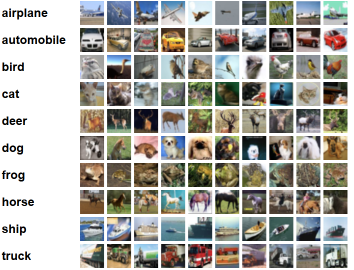

Presumably "airplane" is label[0] and "truck" is label[9]
so...

In [ ]:
# Define the CIFAR-10 classes for annotation
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

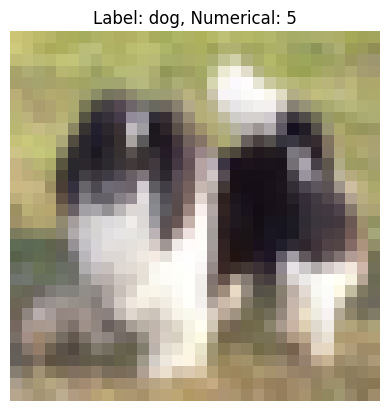

In [ ]:
# Convert the image tensor to a NumPy array and transpose to (32, 32, 3) for plotting
image_np = image.cpu().permute(1, 2, 0).numpy()

# The images were normalised for the "intended use", so we need to un-normalise them for plotting
image_np = image_np * 255.0

# Display the image with its label
plt.imshow(image_np.astype("uint8"))
plt.title(f"Label: {cifar10_classes[label]}, Numerical: {label}")
plt.axis('off')
plt.show()

In [ ]:
# Define model using the code from class
# ORIGINAL - do not change
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512), # 28*28 replaced with 3*32*32 because that seems to be the image size of this data set
            nn.ReLU(), # ReLU makes everything that is negative zero to simulate an excititory neuron in the network
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # Ten classes to predict
            #nn.Softmax() # Softmax seems to make the model perform less well
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Define model using the code from class
class NeuralNetwork_Options(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*32*32, 512), # 28*28 replaced with 3*32*32 because that seems to be the image size of this data set
            nn.ReLU(), # ReLU makes everything that is negative zero to simulate an excititory neuron in the network
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
            nn.Softmax() # Softmax makes a decay to zero in the data rather than a hard cut at zero... some negatives remain according to my notes from class
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Initialize the loss function and optimizer
# Use ADAM as an optimizer as it seemed to perform pretty well last time
# Maybe compare with other optimizers...
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss() # mean absolute error , mse
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# What is the best learning rate?
# scheduler: This is the learning rate scheduler object that you can use to adjust the learning rate during each epoch or training step.
# torch.optim.lr_scheduler.CosineAnnealingLR: This is a specific type of learning rate scheduler in PyTorch that decreases the learning rate following a cosine curve.
# optimizer: This is the optimizer that the learning rate scheduler will modify. The optimizer manages the parameters and updates them based on the learning rate.
# T_max=10: This parameter specifies the maximum number of iterations (or epochs) before the learning rate reaches its minimum value. In this case, T_max=10 means that over the course of 10 epochs, the learning rate will decrease following a cosine curve until it reaches the minimum.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 3. When training - calculate loss etc on both (train and valid) and decide on training success based on validation set

In [ ]:
# Training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    model_pred = None
    for X, y in dataloader: # X is the data and y the label
        X, y = X.to(device), y.to(device) # device is either CPU or GPU

        optimizer.zero_grad() # We don't want the previous gradients to contaminate the optimizer so we reset them
        model_pred = model(X) # data is passed through the model to generate a prediction of the label
        loss = loss_fn(model_pred, y) # loss_fn uses the "cross entropy" model mentioned in class to compare the predicted label (pred) with the actual lable (y). A low value is good
        # Backpropagation: Back propagation is attempting to figure out which of the weights are responsible for most of the error. It does this by calculating the error between the predicted output and actual output and then propagating this error back through the layers to find out how much each weight contributed to the error. Like tuning a radio, the learning rate comes in here and is related to how big a click the weight knob can be turned in one step up or down in order that the overall error can be reduced.
        loss.backward() # Calculate the gradients of the loss
        optimizer.step() # Tune the radio to reduce the error using Adam to estimate how much to tune it by

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss, model_pred

# Validation loop: this can be used for both the validation data during the training and the test data after the best model has been found
def validate_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, correct = 0, 0
    pred = None
    recall = None
    true_positives = 0
    false_negatives = 0
    false_positives = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            y_pred = (pred.argmax(1) == 1).float()
            true_positives += ((y_pred == 1) & (y == 1)).sum().item()
            false_negatives += ((y_pred == 0) & (y == 1)).sum().item()
            false_positives += ((y_pred == 1) & (y == 0)).sum().item()

            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    recall = true_positives / (true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, pred, recall, precision

## 4. Implement your own early stopping: i.e. if validation loss has not decreased over n (to be defined, e.g. 10 or 20) iterations (delta to be defined, e.g. 10^(-4)), training is stopped and the last model is saved - please find out for yourself how to save a torch model

In [ ]:
best_val_accuracy = 0 # So we can tell if the new model gets better
best_pred = None # holds the best prediction to plot the model graph later

train_loss_history = []
recall_history = []
precision_history = []
best_epoch = 0

# Early stopping proposal is to check in each EPOCH how good the model is with the validation set
# If the validation performs better than any previous Epoch then make the current model the best model and set the patience_counter = 0
# If the validation performs worse than than the best model then increase the patience_counter by +1
# If the patience_counter exceeds the patience threshhold then stop training and use the best model found with the test data set
patience, patience_counter = 5, 0 # If the model doesn't improve relative to the best model then stop after this main epochs without improvement

In [ ]:
# Loop training "epochs" number of times
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Run the training from task 3
    train_loss, model_pred = train_loop(train_loader, model, loss_fn, optimizer)
    train_loss_history.append(train_loss)
    # After each attempt at training test the model against the validation set
    val_loss, val_accuracy, pred, recall, precision = validate_loop(val_loader, model, loss_fn)
    recall_history.append(recall)
    precision_history.append(precision)
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {(100*val_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")

    # Check for improvement and if better than before, write out the model to disk
    if val_accuracy > best_val_accuracy: # New model is better than the old model
        best_val_accuracy = val_accuracy
        best_pred = model_pred
        best_epoch = t
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0 # I am interested again, reset my boredom levels
        print("Best model saved.")
    else:
        # If the model is worse then increase the patience_counter until we give up
        patience_counter += 1 # Computer gets slightly more bored when the new model is less good than the best so far
        if patience_counter >= patience: # Boredom threshhold is past so the computer gives up as the model isn't improving
            print("Early stopping triggered. Training stopped. \n")
            break

    # Adjust learning rate
    scheduler.step() # Slightly unclear how this actually works
    print(f"Learning Rate: {scheduler.get_last_lr()[0]} \n")

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
print("Testing on the test dataset with the best model:")
test_loss, test_accuracy, pred, recall, precision = validate_loop(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(100*test_accuracy):>0.1f}%, Recall: {recall}, Precision: {precision}")
print("Done!")

Epoch 1
-------------------------------
Training Loss: 1.8922, Validation Loss: 1.8593, Validation Accuracy: 32.2%, Recall: 0.21696252465483234, Precision: 0.9128630705394191
Best model saved.
Learning Rate: 0.0009755282581475768 

Epoch 2
-------------------------------
Training Loss: 1.7140, Validation Loss: 1.7081, Validation Accuracy: 38.7%, Recall: 0.23964497041420119, Precision: 0.9310344827586207
Best model saved.
Learning Rate: 0.0009045084971874736 

Epoch 3
-------------------------------
Training Loss: 1.6302, Validation Loss: 1.6518, Validation Accuracy: 41.1%, Recall: 0.5315581854043393, Precision: 0.9120135363790186
Best model saved.
Learning Rate: 0.0007938926261462366 

Epoch 4
-------------------------------
Training Loss: 1.5640, Validation Loss: 1.6219, Validation Accuracy: 42.2%, Recall: 0.4822485207100592, Precision: 0.9243856332703214
Best model saved.
Learning Rate: 0.0006545084971874737 

Epoch 5
-------------------------------
Training Loss: 1.4958, Validation 

# 5. Accuracy (also precision and recall)

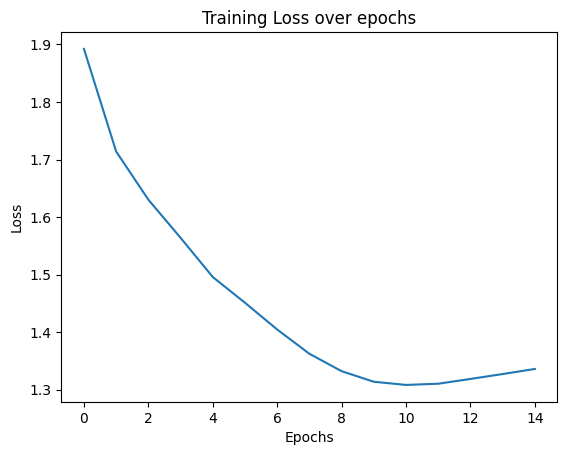

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.show()

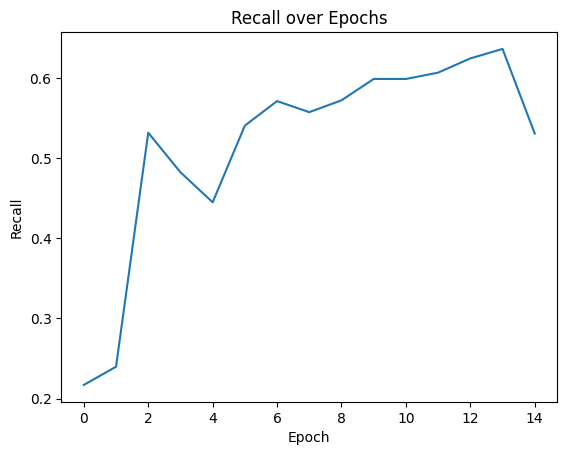

In [ ]:
plt.plot(recall_history)
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.show()

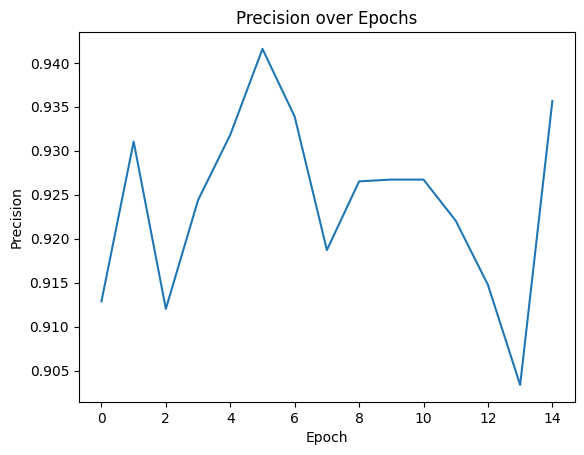

In [ ]:
plt.plot(precision_history)
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.show()

Plotting all curves in one diagram for direct comparison

range(1, 16)
[1.8922424303697372, 1.7139965865149427, 1.6302442372734867, 1.5639626761235155, 1.4958464227505583, 1.4511202398393708, 1.4046206593767667, 1.3624423319088625, 1.3322189700628904, 1.3138393632638683, 1.3083426731227557, 1.31043733462596, 1.3187182638436747, 1.3272681027841466, 1.3360882527284277]


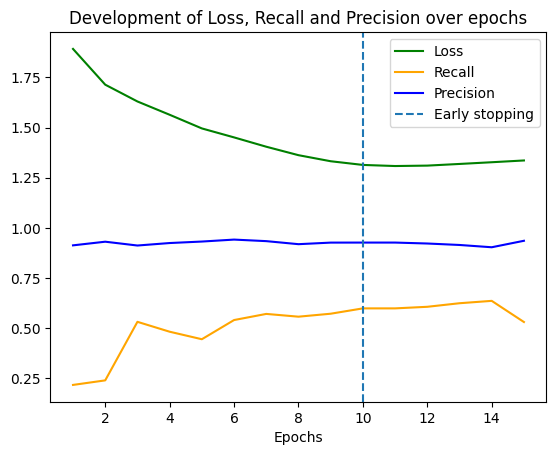

In [ ]:
x_items = range(1, len(train_loss_history) + 1)
print(x_items)
print(train_loss_history)
plt.plot(x_items, train_loss_history, label='Loss', color='green')
plt.plot(x_items, recall_history, label='Recall', color='orange')
plt.plot(x_items, precision_history, label='Precision', color='blue')
plt.xlabel('Epochs')
plt.axvline(x = best_epoch + 1, label='Early stopping', linestyle='dashed' )
plt.title('Development of Loss, Recall and Precision over epochs')
plt.legend()
plt.show()

In [ ]:
# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
print(f'Useed model:\n {model}')  # print the model
print("\nTesting on the test dataset with the best model:")
test_loss, test_accuracy, _, recall, precision = validate_loop(test_loader, model, loss_fn)
print(f"Test Accuracy: {(100*test_accuracy):>0.1f}%, Avg Test loss: {test_loss:>8f}, Recall: {recall}, Precision: {precision}")
print("Done!")

Useed model:
 NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

Testing on the test dataset with the best model:
Test Accuracy: 49.6%, Avg Test loss: 1.434341, Recall: 0.625, Precision: 0.9455370650529501
Done!


In [ ]:
# import missing pip package to render graph
%pip install torchviz
from torchviz import make_dot
from IPython.display import Image, display

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=9c6f5a3c90c9d61e8a62e3067157f3b45b269e2d8f916ed569029d995b07df23
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


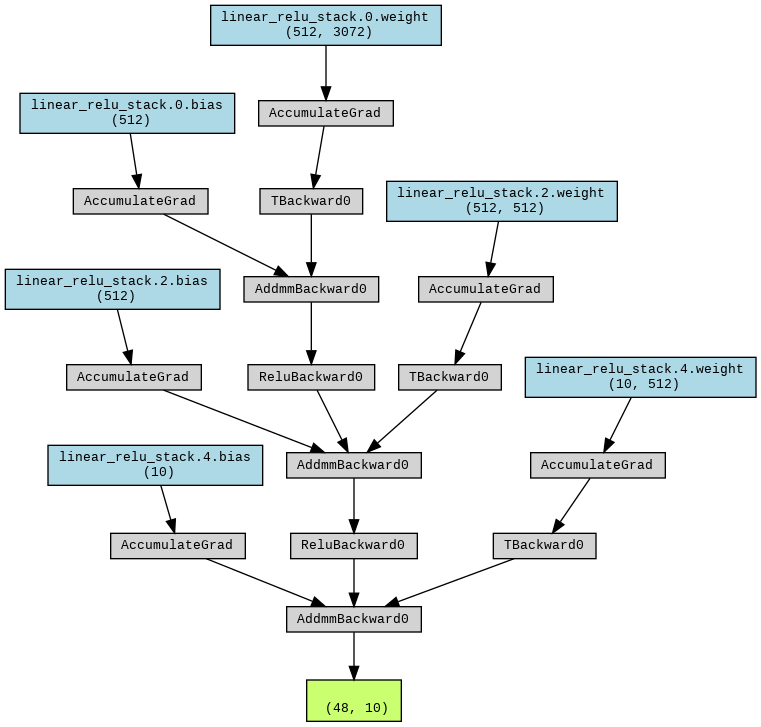

In [ ]:
# creating a graph
graph = make_dot(best_pred, params=dict(model.named_parameters()))
graph.render("model_graph", format="png")

# display a png file in jupyter notebook
display(Image(filename="model_graph.png"))